### This is an end to end complete notebook, demonstrating how Fisher bias can be constructed, given a model and it's uncertainties.
#### This notebook is the work used for the paper : 10.1103/PhysRevD.100.043542
#### The pipeline presented below in short is based on computing the bias that will be propagating into the derived dark energy model, due to the systematics in the photometric redshift. The photo-z error will propagate into the distance estimation $D_L$ which will then bias the dark energy parameters $w_0-w_a$.
#### The modelling is done for Supernova Ia observations keeping LSST future design systematics in mind

In [81]:
import numpy as np
from scipy.integrate import simps
from scipy.integrate import quad
import pandas as pd 
import del_m_fisher_bias_full as m  # CHECK WHICH D0,D1 IS USED
import numpy as np
#import fisher_ayan_function as f
#import dmdtheta_ayan_function as dm
#import fisher_ayan_function_LSST as f
#import fisher_ayan_function_LSST_CMBPrior as f
import sys
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Ellipse
import matplotlib as mpl
import matplotlib.pyplot as plt
#import Fisher_Ellipse_LSST_CMBPrior as F

#### For SN Ia , the magnitude is given by 
### $m=5\log_{10}\left[H_0D_L(z)\right]$ + $M$
#### And the derived dark energy cosmology, mentioned above is parametrised by the CPL dark energy parametrisation :
### $w(z)=w_0+w_a\frac{z}{1+z}$

#### The first step is to locate the parameters $\theta$ on which we want to base our Covariance maitrx or the Fisher matrix. Then we need to compute the partial derivatives w.r.t. $\theta$ for the observable which is magnitude in case of a SN Ia.

# $\frac{dm}{d\theta}$
# $\theta$ = $\{M,m,w_0,w_a\}$

#### Till this point, all we need to know is the :
#### (1) Model observable $m$
#### (2) Fisher parameters $\theta$
#### (3) The scale on which to compute this co-variance, in this case it is the redshift $\textbf{z}$, so we need to know the redshift distribution from the source to the observer, and then we break it up into individual bins and populate those bins with educated survey design feeed knowledge of number of SNe Ia candidates in each of those bins.

In [33]:

Om = 0.3  # Omega Matter
Omatter = (1-Om)
w0 = -1
wa = 0
#w0 = -1.2;wa = -0.9;
#w0 = -0.8;wa = 0.9;
#a = (1+z)**(-1)
# 1
print ('w0, wa used : ', w0, wa)
# Not Required
#---------------------------------

def X(z):
    a = (1+z)**(-1)
    return Om*(a**-3)+((1-Om)*a**(-3)*(a**(-3*(w0+wa))*np.exp(3*wa*(a-1))))


def dxdm(z, wa, w0):
    a = (1+z)**(-1)
    zt = (1+z)
    w = (wa+w0)
    X3 = np.exp(3*wa*(a-1))
    X2 = zt**(3*w)
    X1 = X2*X3
    X4 = 1.-X1
    X = Om*(a**-3)+((1-Om)*a**(-3)*(a**(-3*(w0+wa))*np.exp(3*wa*(a-1))))
    A = (X**(-1.5))*X4*(zt**3)
    #A  = [1-zt**(-3*w)*np.exp(-3*wa*z/zt)]*zt**3
    return A

# 2


def dxdw0(z, wa, w0):
    a = (1+z)**(-1)
    zt = (1+z)
    ztt = z/zt  # z/1+z
    a_a = a**(3*wa)
    a_0 = a**(3*w0)
    e_a = np.exp(3*wa*(-ztt))
    A3 = (a_a**-1)*(-3*np.log(a)/a_0)
    A4 = e_a*A3
    X = Om*(a**-3)+((1-Om)*a**(-3)*(a**(-3*(w0+wa))*np.exp(3*wa*(a-1))))
    A = (X**(-1.5))*Omatter*zt**3*(A4)
    return A


# 3
def dxdwa(z, wa, w0):
    a = (1+z)**(-1)
    a2 = a-1
    zt = (1+z)
    ztt = z/zt
    a_a = a**(3*wa)
    a_0 = a**(3*w0)
    e_a = np.exp(3*wa*(-ztt))
    A3 = e_a*(-3*np.log(a)/a_a)
    A2 = 3*(a-1)*e_a/(a_a)
    A4 = A2+A3
    X = Om*(a**-3)+((1-Om)*a**(-3)*(a**(-3*(w0+wa))*np.exp(3*wa*(a-1))))
    A = (X**(-1.5))*(Omatter)*(zt**3)*(a_0**-1)*(A4)
    return A

# dxdM = 1 

# PRINTING CHECKS
#print 'Redshift  dx/dm      dx/dwo      dx/dwa'
#print '---------------------------------------'
# for i in (np.linspace(0.05,1.65,17)):
#          print("%.4f    %.4f    %.4f     %.4f " %(i,dxdm(i,0,-1),dxdw0(i,0,-1),dxdwa(i,0,-1)) )
# ************************************************************
# ************************************************************


# Integration Part : STARTS FROmatter BELOW

def H_0D_L(z):  # THIS WILL BE THEN INTEGRATED IN LINE NO. 106
    a = (1+z)**(-1)
    sec = (1-Om)*(a**-3)*(a**(-3*(w0+wa))*np.exp(3*(wa*(a-1))))
    fir = (Om*(a**-3))
    return((fir+sec)**(-0.5))


# Z BINS
# z = np.linspace(0.05,1.65,17) # bin means 
z = np.linspace(0.05,1.15,12) # LSST Bins
#z = np.array([0.3, 0.6, 1.0, 1.4, 1.8, 2.0, 2.6, 3.0, 3.3, 4.0])


# ADDITIONAL FUNCTION DECLARATION
def fu1(z):
    return dxdm(z, wa, w0)


def fu2(z):
    return dxdw0(z, wa, w0)


def fu3(z):
    return dxdwa(z, wa, w0)


# VARIABLE DECLARATION
I_om = []
I_wa = []
I_wo = []
hdl = []
prefactor1 = []
dx_domega = []
dx_dwa = []
dx_dw0 = []

# INTEGRATIONS RUNNING FROM LIMIT [0,Z_BIN[i]]
# THE fu FUNCTION CALLS THE OTHER FUNCTION : DX/DTHETA
# QUAD IS A PYTHON INTEGRATION FUNCTION WITH 3 ARGUMENTS :
# FUNCTION TO INTEGRATE, LOWER LIMIT, UPPER LIMIT

for ii in range(len(z[:])):
    #print quad(fu, 0,0.1)
    #       print 'z bin ',z_bin[ii]
    #       print 'z mean',z[ii]
    #       print 'fu1[z]',fu1(z[ii])
    #       print 'quad(fu1,0,%s)'%z[ii]
    #       print 'I_Om :',(quad(fu1,0,z[ii]))
    I_om.append(quad(fu1, 0, z[ii])[0])
    I_wo.append(quad(fu2, 0, z[ii])[0])
    I_wa.append(quad(fu3, 0, z[ii])[0])
    hdl.append((1+z[ii])*quad(H_0D_L, 0, z[ii])[0])  # H0_Dl INTEGRATION
    # PREFACTOR WITHOUT THE H0_Dl TERM. THE 1* STANDS FOR 'c'
    prefactor1.append((-5/np.log(10))*(1*(1+z[ii]))/2)
#       print 'PREFACTOR :',prefactor1[ii]
#print '*******************************************************'

# STORING THE VALUES IN ARRAYS
for i in range(len(I_om)):
    dx_domega.append((prefactor1[i]/hdl[i])*I_om[i])
    dx_dw0.append((prefactor1[i]/hdl[i])*I_wo[i])
    dx_dwa.append((prefactor1[i]/hdl[i])*I_wa[i])
    #print 'DX/Domega_m :',I_om[i]
    dx_dM = np.ones(17)
# WRITING TO A FILE
DXDT = pd.DataFrame(zip(z, dx_domega, dx_dw0, dx_dwa, dx_dM))
DXDT.columns = ['z', 'dmdom', 'dmdwo', 'dmdwa', 'dmdM']
DXDT.to_csv('Fisher_Table_LSST.csv', index=False)


#print DXDT

# PRINT OUTPUT TO SCREEN
# print 'Redshift H0_Dl  dm/domegam      dm/dwo      dm/dwa'#    (3*dm/dwa)/(dm/dwo)'
#print '-------------------------------------------------------------------------'
# for i in range(len(I_om)):
#          print("%.4f    %.4f    %.4f    %.4f     %.4f " %(z[i],hdl[i],dx_domega[i],dx_dw0[i],dx_dwa[i]))#,3*dx_dwa[i]/dx_dw0[i]))

def func():
    return DXDT


w0, wa used :  -1 0


# Fisher_function with CMB Prior for LSST
#### fisher_ayan_function_LSST_CMBPrior.py

In [87]:
DXDT

,z,dmdom,dmdwo,dmdwa,dmdM
0,0.05,-0.081321,-0.054186,-0.000869,1.0
1,0.15,-0.242046,-0.146750,-0.006559,1.0
2,0.25,-0.397791,-0.220662,-0.015324,1.0
3,0.35,-0.546340,-0.278789,-0.025348,1.0
4,0.45,-0.686247,-0.323817,-0.035502,1.0
5,0.55,-0.816734,-0.358155,-0.045128,1.0
6,0.65,-0.937555,-0.383891,-0.053883,1.0
7,0.75,-1.048852,-0.402782,-0.061624,1.0
8,0.85,-1.151025,-0.416276,-0.068332,1.0
9,0.95,-1.244629,-0.425548,-0.074056,1.0


#### Now we are in position to compute the Fisher matrix, for this we need an additional quantity which is 
#### Uncertainty on the running paramter, which is the redshift $z$. In this case, we have systematic and statistical uncertainty for $z$. Parameterized as :
### $\sigma_{syst}=0.01(1+z)$
### $\sigma_{stat}=0.15/\sqrt{N}$, 
#### where $N=10$ is the number of bins that $z$ is broken up between range $[0,1.2]$

#### Once we have that, we compute the Fisher matrix as can be seen in the code cell below, then in addition to it, we add a CMB prior

In [90]:
np.set_printoptions(precision=4)

# Produced by dmdtheta_ayan_function.py
P = pd.read_csv('Fisher_Table_LSST.csv')
dmdom = np.array(P['dmdom'])
dmdwo = np.array(P['dmdwo'])
dmdwa = np.array(P['dmdwa'])
dmdM = np.array(P['dmdM'])
z = np.array(P['z'])
dmdtheta = np.array(list(zip(dmdom, dmdwa, dmdwo, dmdM)))
N_parms = np.shape(dmdtheta)[1]

# ****LSST*****
s = 300*np.ones(10)
s2 = np.array([150, 150])
s2 = np.ndarray.tolist(s2)
s = np.ndarray.tolist(s)
N = np.array(s+s2)
sigma_int_sq = 0.15*0.15
sigma_sys_sq = (0.02*(1+z)/2.)*(0.02*(1+z)/2.)
sigma_sq = sigma_int_sq/N + sigma_sys_sq
# ****LSST*****

F = np.zeros([N_parms, N_parms])
# since its scalar product, so order of the terms doesn't matter
dmdM_dmdM = (np.sum(np.multiply(np.multiply(dmdM, dmdM), (1/sigma_sq))))
dmdom_dmdom = (np.sum(np.multiply(np.multiply(dmdom, dmdom), (1/sigma_sq))))
dmdwa_dmdwa = (np.sum(np.multiply(np.multiply(dmdwa, dmdwa), (1/sigma_sq))))
dmdwo_dmdwo = (np.sum(np.multiply(np.multiply(dmdwo, dmdwo), (1/sigma_sq))))
dmdM_dmdom = (np.sum(np.multiply(np.multiply(dmdM, dmdom), (1/sigma_sq))))
dmdM_dmdwo = (np.sum(np.multiply(np.multiply(dmdM, dmdwo), (1/sigma_sq))))
dmdM_dmdwa = (np.sum(np.multiply(np.multiply(dmdM, dmdwa), (1/sigma_sq))))
dmdom_dmdwa = (np.sum(np.multiply(np.multiply(dmdom, dmdwa), (1/sigma_sq))))
dmdom_dmdwo = (np.sum(np.multiply(np.multiply(dmdom, dmdwo), (1/sigma_sq))))
dmdwa_dmdwo = (np.sum(np.multiply(np.multiply(dmdwa, dmdwo), (1/sigma_sq))))

#dtheta_dtheta = pd.DataFrame(dmdM_dmdM,dmdomegam_dmdomegam)

F_I = np.array([dmdM_dmdM, dmdM_dmdom, dmdM_dmdwo, dmdM_dmdwa, dmdM_dmdom, dmdom_dmdom, dmdom_dmdwo, dmdom_dmdwa,
                dmdM_dmdwo, dmdom_dmdwo, dmdwo_dmdwo, dmdwa_dmdwo, dmdM_dmdwa, dmdom_dmdwa, dmdwa_dmdwo, dmdwa_dmdwa])

Fisher_Matrix = F_I.reshape(4, 4)
Cov_Matrix = np.linalg.pinv(Fisher_Matrix)
C_ij = np.sqrt(np.diag(Cov_Matrix))
# Original prints
#print np.matrix(F_I)
#print '\n\nFisher Matrix \n',Fisher_Matrix
#print '\n\n*****************************\n\n'
#print 'Covariance Matrix \n',Cov_Matrix
#print '\n\n*****************************\n\n'
#print 'sigma_ii \n', C_ij

# ***************************
# CMB PRIOR
F_OmOm = 26282.777992634321
F_Omw0 = -7211.5106699248900
F_Omwa = -1974.3936330616734
F_w0w0 = 1978.7058337978979
F_w0wa = 541.73728345787083
F_wawa = 148.31880478414203
F1 = [F_OmOm, F_Omw0, F_Omwa, F_Omw0, F_w0w0, F_w0wa, F_Omwa, F_w0wa, F_wawa]
F1 = np.reshape(F1, (3, 3))
A1 = np.zeros(16)
A1 = np.reshape(A1, (4, 4))
for row in range(1, np.shape(A1)[0]):
    for col in range(1, np.shape(A1)[1]):
        A1[row][col] += F1[row-1][col-1]
F_Ext = A1 # CMB Matrix


Fisher_Matrix_PRIOR = Fisher_Matrix + F_Ext
Cov_Matrix_PRIOR = np.linalg.pinv(Fisher_Matrix_PRIOR)
C_ij_PRIOR = np.sqrt(np.abs(np.diag(Cov_Matrix_PRIOR)))
#print np.matrix(F_I)

print('\n\n The ORDER IS : dM_dM, domega_m_domega_m, dw0_dw0, dwa_dwa]\n\n')
print ('\n\nFisher Matrix with prior \n', Fisher_Matrix_PRIOR)
#print '\n\n*****************************\n\n'
print ('Covariance Matrix with prior\n', Cov_Matrix_PRIOR)
#print '\n\n*****************************\n\n'
print ('sigma_ii with prior\n', C_ij_PRIOR)


def fisher_matrix():
    return Fisher_Matrix_PRIOR


def covariance_matrix():
    return Cov_Matrix_PRIOR



 The ORDER IS : dM_dM, domega_m_domega_m, dw0_dw0, dwa_dwa]




Fisher Matrix with prior 
 [[ 38595.474  -26024.6156 -10871.46    -1385.7381]
 [-26024.6156  50552.0336   2126.1211   -603.0763]
 [-10871.46     2126.1211   5684.2756   1060.9672]
 [ -1385.7381   -603.0763   1060.9672    226.6198]]
Covariance Matrix with prior
 [[ 3.0269e-04 -1.1137e-05  1.9272e-03 -7.2013e-03]
 [-1.1137e-05  6.8039e-05 -5.3767e-04  2.6302e-03]
 [ 1.9272e-03 -5.3767e-04  1.6886e-02 -6.8702e-02]
 [-7.2013e-03  2.6302e-03 -6.8702e-02  2.8902e-01]]
sigma_ii with prior
 [0.0174 0.0082 0.1299 0.5376]


#### $\sigma_{ii}$ are the (square root) diagonal values of the covariance matrix 

#### del_m_fisher_bias

#### Now we will compute the Fisher bias from the Fisher matrix. The bias, tells exactly how much is the observable offset due to the bias in the running parameter. In our case this tells how much is the $\delta m$ due to $\delta z$. 
### $\Delta m_k = m(z+\delta z) - m(z)$
### $\Delta m_k=\left[(5\log_{10}H_0D_L(z+\delta z)+M) - (5\log_{10}H_0D_L(z)+M)\right]$
### $\Delta m_k = 5\log_{10}\left(\frac{D_L(z+\delta z)}{D_L(z)}\right)$

In [55]:
from scipy.integrate import quad

# **************************
# This program returns the delta_m_k value
# **************************
# (5/ln10)*[delz(1/H*(1/int_0^z'delz/H ) + 1/(1+z))] !!NOT USED HERE!!
# w_a = 0, w_o = -1 , omega_m = 0.3
# H(z) = sqrt(omega_m*(1+z)^3 + (1-omega_m))

# D_L = (1+z) integration(dz/H(z))LIMIT:[0,z]

const = 5/np.log(10)


def H_z(z):
    omega_m = 0.3
    omega_de = 1-omega_m
    hz = omega_m*(1+z)**3+omega_de
    return np.sqrt(hz)


def H_z_inverse(z):
    return 1/(H_z(z))

#d0 =0.   ; d1 =0. ;
#d0 =0.01 ; d1 =0. ;
#d0 =0.   ; d1 =0.01 ;
#print 'd0 = %s, d1 = %s '%(d0,d1)


def del_z(d0, d1, z):
    return (d0+d1*z)


def integration_delz_h(z):
    I = quad(H_z_inverse, 0, z)[0]
    return I


def D_l(z):
    return (1+z)*integration_delz_h(z)


def del_m(z, d0, d1):
    x = const*np.log(D_l(z+del_z(d0, d1, z))/D_l(z))
    return x


for i in np.linspace(0.05, 1.15, 12):
    del_m(i, 0., 0.01)

In [77]:
#print sys.argv[1]
# apply = sys.argv[2] # which bin to apply with dz and omit the rest
z = np.linspace(0.05, 1.15, 12)
dm_dp = func()
sum = []
#d0 = [0.,0.01,0.]
#d1 = [0.,0.,0.01]
do_d1 = [[0., 0.], [0.01, 0.], [0., 0.01]]
cs1 = []
cs2 = []
cs3 = []

#print 'Case 1  : d0, d1  %s'%(do_d1[0])
for i in (z):
    #print i
    x1 = del_m(i, do_d1[0][0], do_d1[0][1])  # + 1.4/(1+i)*(m.del_z(z,d0,d1))
#    print x1
    cs1.append(x1)
#print 'Case 2  : d0, d1  %s'%(do_d1[1])
for i in (z):
    x2 = del_m(i, do_d1[1][0], do_d1[1][1])
#    print x2
    cs2.append(x2)
#print 'Case 3  : d0, d1  %s'%(do_d1[2])
for i in (z):
    x3 = del_m(i, do_d1[2][0], do_d1[2][1])
#    print x3
    cs3.append(x3)
print ('***********************\nFull expressions : No Approxiamtion')
print ('************************\n\ndel_m with 3 different sets of d0,d1\n')

print ("0,0       0.01,0    0,0.01\n")
for i in range(len(cs2)):
    print("%.4f    %.4f    %.4f  " % (cs1[i], cs2[i], cs3[i]))
print ('***********************')
s = 300*np.ones(10)
s2 = np.array([150, 150])
s2 = np.ndarray.tolist(s2)
s = np.ndarray.tolist(s)
N = np.array(s+s2)
sigma_int_sq = 0.15*0.15
sigma_sys_sq = (0.02*(1+z)/2.)*(0.02*(1+z)/2.)
sigma_sq = sigma_int_sq/N + sigma_sys_sq

print ('N :  ', N)  # OK
print ('sigma_square : ', sigma_sq)


'''
if sys.argv[1] == value : #'1':
    flag = cs1
elif sys.argv[1] == value : # '2':
    flag = cs2
elif sys.argv[1] == value : # '3':
    flag = cs3
'''  
value = '2'
if value == '1':
    flag = cs1
elif value == '2' : # '2':
    flag = cs2
elif value == '3' : # '3':
    flag = cs3    
    
    
# flag = cs3 # **** FLAG SET
del_m_sigma_sq = flag/sigma_sq  # cs1 is used
cov = covariance_matrix()
XX_om = 0.
XX_wa = 0.
XX_w0 = 0.0
XX_M = 0.
for n in range(len(dm_dp)):
    XX_om += dm_dp['dmdom'][n]*del_m_sigma_sq[n]
    XX_w0 += dm_dp['dmdwo'][n]*del_m_sigma_sq[n]
    XX_wa += dm_dp['dmdwa'][n]*del_m_sigma_sq[n]
    XX_M += dm_dp['dmdM'][n] * del_m_sigma_sq[n]
arr = [XX_M, XX_om, XX_w0, XX_wa]
if flag == cs1:
    print ('\n********\nUsing d0 , d1 :0.0, 0\n********\n')  # Change L 40 also
    comment = 'd0 = %s, d1 = %s' % (do_d1[0][0], do_d1[0][1])
    ide = str(do_d1[0][0])+'_'+str(do_d1[0][1])
elif flag == cs2:
    print ('\n********\nUsing d0 , d1 :0.01, 0\n********\n')  # Change L 40 also
    comment = 'd0 = %s, d1 = %s' % (do_d1[1][0], do_d1[1][1])
    ide = str(do_d1[1][0])+'_'+str(do_d1[1][1])
elif flag == cs3:
    print ('\n********\nUsing d0 , d1 :0., 0.01\n********\n')  # Change L 40 also
    comment = 'd0 = %s, d1 = %s' % (do_d1[2][0], do_d1[2][1])
    ide = str(do_d1[2][0])+'_'+str(do_d1[2][1])

print ('\ncov : \n', cov)
print ('\ndel_m / sigma_sq\n', del_m_sigma_sq)
print ('array of 4 vectors\n %s' % arr)
del_p2 = cov.dot(arr)
print ('\ndel_p2 : \n', (del_p2))
name = 'del_p_LSST_%s.txt' % ide
np.savetxt(name, np.matrix(del_p2), fmt='%.4f')

***********************
Full expressions : No Approxiamtion
************************

del_m with 3 different sets of d0,d1

0,0       0.01,0    0,0.01

0.0000    0.4114    0.0224  
0.0000    0.1536    0.0236  
0.0000    0.0969    0.0246  
0.0000    0.0715    0.0252  
0.0000    0.0569    0.0257  
0.0000    0.0473    0.0261  
0.0000    0.0404    0.0263  
0.0000    0.0353    0.0265  
0.0000    0.0313    0.0266  
0.0000    0.0281    0.0267  
0.0000    0.0255    0.0267  
0.0000    0.0233    0.0267  
***********************
N :   [300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 150. 150.]
sigma_square :  [0.0002 0.0002 0.0002 0.0003 0.0003 0.0003 0.0003 0.0004 0.0004 0.0005
 0.0006 0.0006]

********
Using d0 , d1 :0.01, 0
********


cov : 
 [[ 3.0269e-04 -1.1137e-05  1.9272e-03 -7.2013e-03]
 [-1.1137e-05  6.8039e-05 -5.3767e-04  2.6302e-03]
 [ 1.9272e-03 -5.3767e-04  1.6886e-02 -6.8702e-02]
 [-7.2013e-03  2.6302e-03 -6.8702e-02  2.8902e-01]]

del_m / sigma_sq
 [2220.971   741.272   419.240

# Ploting the Fisher Ellipse

In [79]:
#The Marginalized [2X2] subset of COVARIANCE Matrix.
# Here Marginalized over M, omega_m
# Obtained from : fisher_ayan_function_LSST_CMBPrior.py
F = [0, -1, 2.8902e-01, 1.6886e-02, -6.8702e-02]
# F = [0, -1,  3.5020e-01,  7.3036e-03, -3.1243e-02]  # Used
# F = [wa,wo,wawa,wowo,wowa]  wa, w0, sigma_aa, sigma_00, sigma_a0
alpha = 1.52    # arxiv : 0906.4123. 1-s CL
print ('The Height and Width roughly is %.2f  %.2f' % (
    2*alpha*np.sqrt(F[3]), 2*alpha*np.sqrt(F[2])))


def a_square(sigma_x, sigma_y, sigma_xy):
    F = sigma_x + sigma_y
    G = (sigma_x - sigma_y)**2
    H = (G/4) + sigma_xy**2
    A = F/2 + np.sqrt(H)
    #print 'A^2 :',A
    return A


def b_square(sigma_x, sigma_y, sigma_xy):
    F = sigma_x + sigma_y
    G = (sigma_x - sigma_y)**2
    H = (G/4) + sigma_xy**2
    B = F/2 - np.sqrt(H)
    #print 'F, G, H',F,G,H
    #print np.sqrt(H)
    #print 'B^2 :',B
    return B


def tan_two_theta(sigma_x, sigma_y, sigma_xy):
    print ('theta :', -math.degrees(0.5*math.atan(2*sigma_xy/(sigma_x-sigma_y))))
    return(0.5*math.atan(2*sigma_xy/(sigma_x-sigma_y)))


def area(sigma_x, sigma_y, sigma_xy):
    return np.pi*(np.sqrt(a_square(sigma_x, sigma_y, sigma_xy))*alpha)*(np.sqrt(b_square(sigma_x, sigma_y, sigma_xy))*alpha)


def par(sigma_x, sigma_y, sigma_xy):
    a_star = np.sqrt(np.abs(a_square(sigma_x, sigma_y, sigma_xy)))*2*1.52
    b_star = np.sqrt(np.abs(b_square(sigma_x, sigma_y, sigma_xy)))*2*1.52
    two_theta = tan_two_theta(sigma_x, sigma_y, sigma_xy)
    param = [a_star, b_star, two_theta]
    #param = [2*alpha*np.sqrt(F[3]),2*alpha*np.sqrt(F[2]),two_theta]

    #param = [a_star/alpha,b_star/alpha,two_theta]
    #print 'a_star, b_star, 1/2*atan(2sigma_xy/sigma_x^2-sigma_y^2) : \n',param[0],param[1],param[2]
    return param

#tan_two_theta(7.3036e-03,3.5020e-01, -3.1243e-02)
#par(7.3036e-03,3.5020e-01, -3.1243e-02)


The Height and Width roughly is 0.40  1.63


theta : 13.394902309736473
Width :  0.06967731906730495
Height : 1.679942249247751
Angle : 13.394902309736473


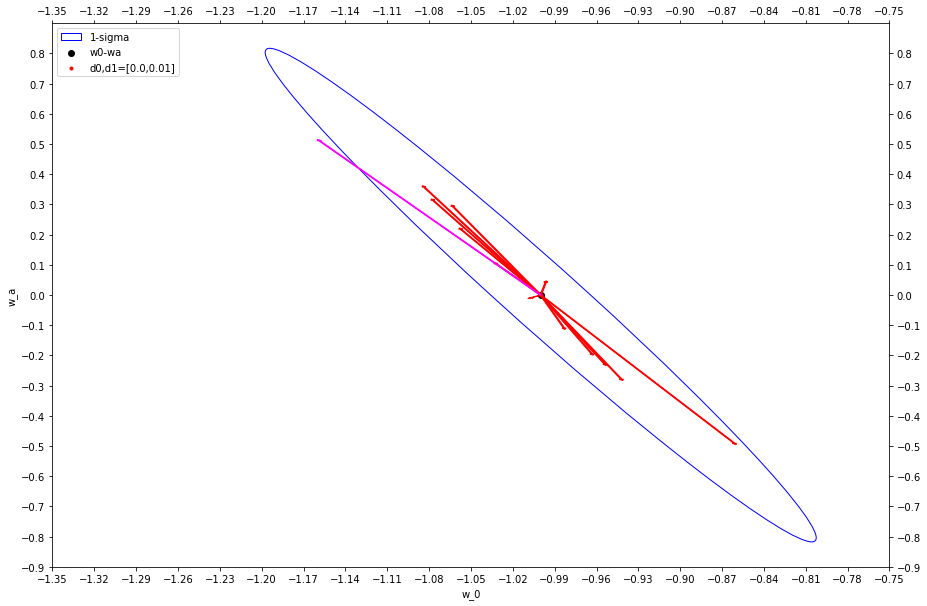

In [85]:
plt.rcParams['figure.figsize'] = [15,10] 
alpha = 1.52
# angle = F.tan_two_theta() # In radian
params = par(F[2], F[3], F[4])
# xy   = centers = w_o,w_a = -1,0
#width = sigma_w_oo
#height= sigma_w_aa
# angle = sigma_w_ao/sqrt(sigma_w_oo*sigma_w_aa)  = 0.5716
#print '5 vectors', F.F
print ('Width : ', params[1])
print ('Height :', params[0])
print ('Angle :', -math.degrees(params[2]))

ell = mpl.patches.Ellipse(xy=[-1, 0], width=params[1], height=params[0], angle=-
                          math.degrees(params[2]), facecolor='none', edgecolor='b', label='1-sigma')
#ell = mpl.patches.Ellipse(xy=[-1,0], width=2*1.52*np.sqrt(F.F[2]), height=2*1.52*np.sqrt(F.F[3]), angle = math.degrees(F.par(F.F[2],F.F[3],F.F[4])[2]),facecolor='none',edgecolor='b',label='1-sigma')
#ell = mpl.patches.Ellipse(xy=[-1,0], width=4.28, height=209.2915, angle = 0.5716*180/np.pi,facecolor='darkgray',edgecolor='b',label='1-sigma')


fig, ax = plt.subplots()
ax.add_patch(ell)
ax.set_aspect('auto')
ax.set_facecolor('none')
ax.autoscale()  # ''tight
ax.scatter(F[1], F[0], c='black', marker='o', label='w0-wa')
# ax.axvline(x=-1,alpha=0.5,c='black',ls='--')
# ax.axhline(y=0,alpha=0.5,c='black',ls='--')
ax.set_xlabel('w_0')
ax.set_ylabel('w_a')
# ax.set_xlim(-1.7,-0.7)
ax.set_xlim(-1.35, -0.75)
ax.set_ylim(-0.9, 0.9)
# ax.set_ylim(-3,3.0)
#ax.axvline(x=-0.871,ls = '--',c='green');ax.axvline(x=-1.129,c='green',ls='--',label='del w_0 ~ %.2f'%(2*alpha*np.sqrt(F.F[2])));
#ax.axhline(y=0.9,ls = '--',c='cyan');ax.axhline(y=-0.9,ls='--',c='cyan',label='del w_a ~ %.2f'%(2*alpha*np.sqrt(F.F[3])))
ax.tick_params(labeltop=True, labelright=True)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.xticks(np.arange(-1.35, -0.75, 0.03))
plt.yticks(np.arange(-0.9, 0.9, 0.1))


# x_slope =[4.35,-6.3,-1]   #[-9.6,7.7,-1]# [4.35,-6.3,-1]
# y_slope = [-12.3,12.3,0]#[7.7,-7.3,0]#[-12.3,12.3,0]
# plt.plot(x_slope,y_slope)


r = pd.read_csv('del_p2_Long.dat')  # READING in the d_w0,d_wa data
del_w0_1 = r.iloc[12:24]['del_w0']  # d0,d1 = (0,0.01) , the x axis
del_wa_1 = r.iloc[12:24]['del_wa']  # d0,d1 = (0,0.01) , the y axis

del_w0_1_11 = r.iloc[3]['del_w0']
del_wa_1_11 = r.iloc[3]['del_wa']

del_w0_2 = r.iloc[36:]['del_w0']  # d0,d1 = (0.01,0)
del_wa_2 = r.iloc[36:]['del_wa']  # d0,d1 = (0.01,0)

del_w0_2_11 = r.iloc[27]['del_w0']
del_wa_2_11 = r.iloc[27]['del_wa']

for i in range(12):
    a1 = plt.arrow(-1, 0, del_w0_1.iloc[i], del_wa_1.iloc[i],
                   color='red', label='d0,d1=[0,0.01]')
    # a2=plt.arrow(-1,0,del_w0_2.iloc[i],del_wa_2.iloc[i],color='green',label='d0,d1=[0.01,0]')
    #plt.legend([a1,a2,], ['d0,d1=[0,0.01]','d0,d1=[0.0,0.0]',])
a_1_11 = plt.arrow(-1, 0, del_w0_1_11, del_wa_1_11, color='magenta')
# a_2_11=plt.arrow(-1,0,del_w0_2_11,del_wa_2_11,color='greenyellow')

plt.scatter(-1, 0, c='red', marker='.', label='d0,d1=[0.0,0.01]')
# plt.scatter(-1,0,c='green',marker='.',label='d0,d1=[0.01,0.0]')

plt.legend()
plt.savefig('./github/Ellipse_LSST_CMBPrior_1.png')
plt.show()

#### More option enabled version of the del_p code cell below

In [95]:
#!/usr/bin/python

# ADDITION OF STRETCH FACTOR IN BIAS TERM. LINE 26 ONWARDS
# TWO ARGUMENTS PROVIDED :
# 1 = OPTIONS : [1-7]
# WHICH BINS TO APPLY THE del_z AND WHICH COMBINATION
# OF d0,d1 TO APPLY
# THE FIRST 3 BASES APPLY D0,D1 = 0,(0.01,0),(0,0.01),
# UNIFORMLY ON ALL THE 12 z BINS
# THE NEXT 4 CASES IN ARGV[1] SELECTIVELY APPLIES THE TWO
# NON-ZERO d0,d1 CASES TO THE 12 BINS

# THE SECOND ARGUMENT : OPTIONS [1-12]
# WHICH BIN TO SELECT OUT OF 12 TO APPLY
# del_z OR WHICH BIN TO EXCLUDE FOR APPLYING
# THE del_z

'''
import del_m_fisher_bias_full as m  # CHECK WHICH D0,D1 IS USED
import numpy as np
#import fisher_ayan_function as f
import dmdtheta_ayan_function as dm
#import fisher_ayan_function_LSST as f
import fisher_ayan_function_LSST_CMBPrior as f
import pandas as pd
import sys
'''

#print option]
apply = 11#int(sys.argv[2])-1  # which bin to apply with dz and omit the rest********************      <<<<-----
print ('****** z - Bin to work on : ', apply+1)
counter = 0
z = np.linspace(0.05, 1.15, 12)
dm_dp = func()
sum = []
#d0 = [0.,0.01,0.]
#d1 = [0.,0.,0.01]
do_d1 = [[0., 0.], [0.01, 0.], [0., 0.01]]
cs1 = []
cs2 = []
cs3 = []
cs4 = []
cs5 = []
cs6 = []
cs7 = []
cols = ['d0', 'd1', 'bin_used', 'how']
dat1 = pd.DataFrame(columns=cols)
dat2 = pd.DataFrame(columns=cols)
dat3 = pd.DataFrame(columns=cols)
dat4 = pd.DataFrame(columns=cols)
dat5 = pd.DataFrame(columns=cols)
dat6 = pd.DataFrame(columns=cols)
dat7 = pd.DataFrame(columns=cols)


#print 'Case 1  : d0, d1  %s'%(do_d1[0])
for i in (z):
    #print i
    x1 = del_m(i, do_d1[0][0], do_d1[0][1]) + \
        (1.4/(1+i)*(del_z(do_d1[0][0], do_d1[0][1], i)))
#    print x1
    cs1.append(x1)
dat1 = dat1.append({'d0': str(do_d1[2][0]), 'd1': str(
    do_d1[2][1]), 'bin_used': str(0), 'how': str(0)}, ignore_index=True)
#print 'Case 2  : d0, d1  %s'%(do_d1[1])
for i in (z):
    x2 = del_m(i, do_d1[1][0], do_d1[1][1]) + \
        (1.4/(1+i)*(del_z(do_d1[1][0], do_d1[1][1], i)))
   # print'Stretch factor : ', (1.4/(1+i)*(del_z(do_d1[1][0],do_d1[1][1],i)))
    cs2.append(x2)
dat2 = dat2.append({'d0': str(do_d1[1][0]), 'd1': str(
    do_d1[1][1]), 'bin_used': str(0), 'how': str(0)}, ignore_index=True)
#print 'Case 3  : d0, d1  %s'%(do_d1[2])
for i in (z):
    x3 = del_m(i, do_d1[2][0], do_d1[2][1]) + \
        (1.4/(1+i)*(del_z(do_d1[2][0], do_d1[2][1], i)))
    #print'Stretch factor : ', (1.4/(1+i)*(del_z(do_d1[2][0],do_d1[2][1],i)))
    #print'Difference : ',x3-(1.4/(1+i)*(del_z(do_d1[2][0],do_d1[2][1],i)))
    cs3.append(x3)
dat3 = dat3.append({'d0': str(do_d1[2][0]), 'd1': str(
    do_d1[2][1]), 'bin_used': str(0), 'how': str(0)}, ignore_index=True)
for i in (z):  # APPLY ONLY ON ONE BIN
    if apply == counter:
        #        print 'Condition match'
        #        print 'counter :',counter
        #        print 'apply :',apply
        x4 = del_m(i, do_d1[1][0], do_d1[1][1]) + (1.4/(1+i)
                                                     * (del_z(do_d1[1][0], do_d1[1][1], i)))  # 0.01,0
    else:
        x4 = del_m(i, do_d1[0][0], do_d1[0][1])
    counter += 1
    cs4.append(x4)
dat4 = dat4.append({'d0': str(do_d1[1][0]), 'd1': str(
    do_d1[1][1]), 'bin_used': str(apply+1), 'how': str(1)}, ignore_index=True)
counter = 0
for i in (z):  # APPLY ONLY ON ONE  BIN
    if apply == counter:
        #        print 'Condition match'
        #        print 'counter :',counter
        #        print 'apply :',apply
        x5 = del_m(i, do_d1[2][0], do_d1[2][1]) + (1.4/(1+i)
                                                     * (del_z(do_d1[2][0], do_d1[2][1], i)))  # 0.0,0.01
    else:
        x5 = del_m(i, do_d1[0][0], do_d1[0][1])
    counter += 1
    cs5.append(x5)
dat5 = dat5.append({'d0': str(do_d1[2][0]), 'd1': str(
    do_d1[2][1]), 'bin_used': str(apply+1), 'how': str(1)}, ignore_index=True)
counter = 0
for i in (z):  # APPLY ON ALL BIN EXCEPT ONE
    #    print 'All BIn Except One : 6'
    if apply != counter:
        x6 = del_m(i, do_d1[1][0], do_d1[1][1]) + (1.4/(1+i)
                                                     * (del_z(do_d1[1][0], do_d1[1][1], i)))  # 0.01,0
    else:
        x6 = del_m(i, do_d1[0][0], do_d1[0][1])
    counter += 1
    cs6.append(x6)
dat6 = dat6.append({'d0': str(do_d1[1][0]), 'd1': str(
    do_d1[1][1]), 'bin_used': str(apply+1), 'how': str(11)}, ignore_index=True)
counter = 0
for i in (z):  # APPLY ON ALL BIN EXCEPT ONE
    #    print 'All BIn Except One : 7'
    if apply != counter:
        x7 = del_m(i, do_d1[2][0], do_d1[2][1]) + (1.4/(1+i)
                                                     * (del_z(do_d1[2][0], do_d1[2][1], i)))  # 0.0,0.01
    else:
        x7 = del_m(i, do_d1[0][0], do_d1[0][1])
    counter += 1
    cs7.append(x7)
dat7 = dat7.append({'d0': (do_d1[2][0]), 'd1': str(
    do_d1[2][1]), 'bin_used': str(apply+1), 'how': str(11)}, ignore_index=True)


#print '***********************\nFull expressions : No Approxiamtion'
#print '************************\n\ndel_m with 3 different sets of d0,d1\n'

#print "0,0       0.01,0    0,0.01\n"
# for i in range(len(cs2)):
#    print("%.4f    %.4f    %.4f  ")%(cs1[i],cs2[i],cs3[i])
#print '***********************'
s = 300*np.ones(10)
s2 = np.array([150, 150])
s2 = np.ndarray.tolist(s2)
s = np.ndarray.tolist(s)
N = np.array(s+s2)
sigma_int_sq = 0.15*0.15
sigma_sys_sq = (0.02*(1+z)/2.)*(0.02*(1+z)/2.)
sigma_sq = sigma_int_sq/N + sigma_sys_sq

# print 'N :  ',N # OK
#print 'sigma_square : ',sigma_sq
option = '5'# *************************************************************************      <<<<-----
if option == '1':
    flag = cs1
    print_d = do_d1[0]
    dat = dat1
elif option == '2':
    flag = cs2
    print_d = do_d1[1]
    dat = dat2
elif option == '3':
    flag = cs3
    print_d = do_d1[2]
    dat = dat3
elif option == '4':  # only one bin [0.01,0]
    flag = cs4
    print_d = do_d1[1]
    dat = dat4
elif option == '5':  # only one bin [0,0.01]
    flag = cs5
    print_d = do_d1[2]
    dat = dat5
elif option == '6':  # except one bin [0.01,0]
    flag = cs6
    print_d = do_d1[1]
    dat = dat6
elif option == '7':  # except one bin [0,0.01]
    flag = cs7
    print_d = do_d1[2]
    dat = dat7

# flag = cs3 # **** FLAG SET
del_m_sigma_sq = flag/sigma_sq  # cs1 is used
cov = covariance_matrix()
XX_om = 0.
XX_wa = 0.
XX_w0 = 0.0
XX_M = 0.
for n in range(len(dm_dp)):
    XX_om += dm_dp['dmdom'][n]*del_m_sigma_sq[n]
    XX_w0 += dm_dp['dmdwo'][n]*del_m_sigma_sq[n]
    XX_wa += dm_dp['dmdwa'][n]*del_m_sigma_sq[n]
    XX_M += dm_dp['dmdM'][n] * del_m_sigma_sq[n]
arr = [XX_M, XX_om, XX_w0, XX_wa]
if flag == cs1:
    print ('\n********\nUsing d0 , d1 :0.0, 0\n********\n')  # Change L 40 also
    comment = 'd0 = %s, d1 = %s' % (do_d1[0][0], do_d1[0][1])
    ide = str(do_d1[0][0])+'_'+str(do_d1[0][1])
elif flag == cs2:
    print ('\n********\nUsing d0 , d1 :0.01, 0\n********\n')  # Change L 40 also
    comment = 'd0 = %s, d1 = %s' % (do_d1[1][0], do_d1[1][1])
    ide = str(do_d1[1][0])+'_'+str(do_d1[1][1])
elif flag == cs3:
    print ('\n********\nUsing d0 , d1 :0., 0.01\n********\n' ) # Change L 40 also
    comment = 'd0 = %s, d1 = %s' % (do_d1[2][0], do_d1[2][1])
    ide = str(do_d1[2][0])+'_'+str(do_d1[2][1])
elif flag == cs4:
    print ('\n********\nUsing d0 , d1 :0.01, 0\n****1 bin del_z****\n')  # Change L 40 also
    comment = 'd0 = %s, d1 = %s' % (do_d1[1][0], do_d1[1][1])
    ide = str(do_d1[1][0])+'_'+str(do_d1[1][1])+'_1_bin_'+str(apply+1)
elif flag == cs5:
    print ('\n********\nUsing d0 , d1 :0., 0.01\n****1 bin del_z****\n')  # Change L 40 also
    comment = 'd0 = %s, d1 = %s' % (do_d1[2][0], do_d1[2][1])
    ide = str(do_d1[2][0])+'_'+str(do_d1[2][1])+'_1_bin_'+str(apply+1)
elif flag == cs6:
    print ('\n********\nUsing d0 , d1 :0.01, 0\n****11 bins del_z****\n')  # Change L 40 also
    comment = 'd0 = %s, d1 = %s' % (do_d1[1][0], do_d1[1][1])
    ide = str(do_d1[1][0])+'_'+str(do_d1[1][1])+'_11_bin'+'_'+str(apply+1)
elif flag == cs7:
    print ('\n********\nUsing d0 , d1 :0., 0.01\n****11 bins del_z****\n')  # Change L 40 also
    comment = 'd0 = %s, d1 = %s' % (do_d1[2][0], do_d1[2][1])
    ide = str(do_d1[2][0])+'_'+str(do_d1[2][1])+'_11_bin'+'_'+str(apply+1)

#print '\ncov : \n',cov
#print '\ndel_m / sigma_sq\n',del_m_sigma_sq
#print 'array of 4 vectors\n %s'%arr
del_p2 = cov.dot(arr)
columns = ['M', 'omegam', 'w0', 'wa']
delt = pd.DataFrame(columns=columns)
delt = delt.append({'M': del_p2[0], 'omegam':  del_p2[1],
                    'w0':  del_p2[2], 'wa':  del_p2[3]}, ignore_index=True)
print ('\ndel_p2 (using d0,d1 = %s ): %s\n' % (print_d, del_p2))
data2 = pd.concat([delt, dat], axis=1)
name = 'del_p_LSST_CMBPrior_Stretch_%s.txt' % ide
name2 = 'del_p_LSST_CMBPrior_Stretch_LONG_%s.txt' % ide
np.savetxt(name, np.matrix(del_p2), fmt='%.4f')
data2.to_csv(name2, index=False)

****** z - Bin to work on :  12

********
Using d0 , d1 :0., 0.01
****1 bin del_z****


del_p2 (using d0,d1 = [0.0, 0.01] ): [ 0.0043 -0.0051  0.0579 -0.2786]

